In [64]:
dir = '/scratch/franzihe/input/CloudSat/2C-SNOW-PROFILE.P1_R05/'

In [65]:
from glob import glob
ff_cs = sorted(glob(dir+'2006/*/*.h5'))

In [66]:
import h5py
import datetime
import numpy as np
import xarray as xr

In [67]:
GEOLOC_VARNAMES = ["DEM_elevation","Height", "Latitude", "Longitude"]
DATA_VARNAMES = ["snow_water_content", "snowfall_rate", "snowfall_rate_sfc"]


In [68]:
def get_profile_times(h5file):
    time_offset_seconds = get_geoloc_var(h5file, 'Profile_time')
    UTC_start_time_seconds = get_geoloc_var(h5file, 'UTC_start')[0]
    start_time_string = h5file['Swath Attributes']['start_time'][0][0].decode("UTF-8")
    YYYYmmdd = start_time_string[0:8]
    base_time = datetime.datetime.strptime(YYYYmmdd, '%Y%m%d')
    UTC_start_offset = datetime.timedelta(seconds=UTC_start_time_seconds)
    profile_times = np.array([base_time + UTC_start_offset + datetime.timedelta(seconds = x) for x in time_offset_seconds])

    da = xr.DataArray(data=profile_times,
                     dims=["nray"],
                     coords=dict(
                         nray= range(len(profile_times)),),
                     attrs=dict(description="time",)
                     )
    return(da)

In [69]:
def get_geoloc_var(h5file, varname, ):
    var_value = h5file['Geolocation Fields'][varname][:]
    var_value = var_value.astype(float)
    factor    = h5file['Swath Attributes'][varname + ".factor"][0][0]
    offset    = h5file['Swath Attributes'][varname + ".offset"][0][0]
    var_value = (var_value - offset)/factor

    if varname == 'DEM_elevation':
        var_value[var_value < 0.] = 0.
    if varname == 'Height' or varname == 'DEM_elevation' or varname == 'Vertical_binsize':
        # mask missing values
        var_value[var_value == h5file['Swath Attributes'][varname + ".missing"][0][0]] = np.nan

    if varname == 'Latitude' or varname == 'Longitude' or varname == 'Height' or varname == 'DEM_elevation' or varname == 'Vertical_binsize':
        if var_value.ndim == 1:
            da = xr.DataArray(data=var_value,
                             dims=["nray"],
                             coords=dict(
                                nray= range(len(var_value)),),
                             attrs=dict(
                                longname=h5file['Swath Attributes'][varname + '.long_name'][0][0].decode("UTF-8"),
                                units = h5file['Swath Attributes'][varname + '.units'][0][0].decode("UTF-8"),),
                    )
        if var_value.ndim == 2:
            da = xr.DataArray(data=var_value,
                             dims=["nray", "nbin"],
                             coords=dict(
                                nray= range(var_value.shape[0]), 
                                nbin = range(var_value.shape[1])),
                             attrs=dict(
                                longname=h5file['Swath Attributes'][varname + '.long_name'][0][0].decode("UTF-8"),
                                units = h5file['Swath Attributes'][varname + '.units'][0][0].decode("UTF-8"),),
                    )
        return(da)

    else:
        return(var_value)
                      


In [70]:
def get_data_var(h5file, varname):
    var_value = h5file['Data Fields'][varname][:]
    var_value = var_value.astype(float)
    factor    = h5file['Swath Attributes'][varname + ".factor"][0][0]
    offset    = h5file['Swath Attributes'][varname + ".offset"][0][0]
    var_value = (var_value - offset)/factor

    var_value[var_value == h5file['Swath Attributes'][varname + ".missing"][0][0]] = np.nan

    if var_value.ndim == 1:
        da = xr.DataArray(data=var_value,
                         dims=["nray"],
                         coords=dict(
                            nray= range(len(var_value)),),
                         attrs=dict(
                            longname=h5file['Swath Attributes'][varname + '.long_name'][0][0].decode("UTF-8"),
                            units = h5file['Swath Attributes'][varname + '.units'][0][0].decode("UTF-8"),),
                )
    if var_value.ndim == 2:
        da = xr.DataArray(data=var_value,
                         dims=["nray", "nbin"],
                         coords=dict(
                            nray= range(var_value.shape[0]), 
                            nbin = range(var_value.shape[1])),
                         attrs=dict(
                            longname=h5file['Swath Attributes'][varname + '.long_name'][0][0].decode("UTF-8"),
                            units = h5file['Swath Attributes'][varname + '.units'][0][0].decode("UTF-8"),),
                )
    return(da)

In [71]:
datasets = []

for file in ff_cs:
    year = int(file.split('/')[-1].split('_')[0][0:4])
    doy = int(file.split('/')[-1].split('_')[0][4:7])  # day of the year
    tt = datetime.datetime(year, 1, 1) + datetime.timedelta(doy - 1)

    for month in range(1, 13):
        if tt.month == month:
            ds = xr.Dataset()
            
            h5file = h5py.File(file, "r")   # open h5 file
            ds['Profile_time'] = get_profile_times(h5file['2C-SNOW-PROFILE'])

            for var in GEOLOC_VARNAMES:
                ds[var] = get_geoloc_var(h5file['2C-SNOW-PROFILE'], var )

            for var in DATA_VARNAMES:
                ds[var] = get_data_var(h5file['2C-SNOW-PROFILE'], var)

            datasets.append(ds)

    combined = xr.concat(datasets,dim='nray')


In [73]:
combined['Profile_time']

<xarray.DataArray 'Profile_time' (nray: 15203668)>
array(['2006-06-02T13:42:23.226562000', '2006-06-02T13:42:23.386562000',
       '2006-06-02T13:42:23.546562000', ...,
       '2006-07-01T21:26:33.359863000', '2006-07-01T21:26:33.519531000',
       '2006-07-01T21:26:33.679688000'], dtype='datetime64[ns]')
Coordinates:
  * nray     (nray) int64 0 1 2 3 4 5 6 ... 37076 37077 37078 37079 37080 37081
Attributes:
    description:  time

In [74]:
import matplotlib.pyplot as plt  # the plotting interface
import cartopy.crs as ccrs  # for plotting in cartographic projection

In [75]:
import intake

xr.set_options(display_style="html")


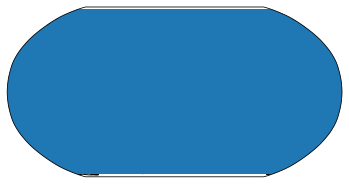

In [76]:
fig = plt.figure()

ax = fig.add_subplot(111, projection=ccrs.Robinson())
ax.coastlines()
ax.set_global()

ax.plot(combined['Longitude'], combined['Latitude'], linewidth=2, transform=ccrs.PlateCarree());

In [12]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)

In [16]:
cat = col.search(variable_id='prsn', source_id='NorESM2-MM', experiment_id='historical', table_id = 'Amon', member_id=['r1i1p1f1'])
dset_dict = cat.to_dataset_dict(zarr_kwargs={'use_cftime':True,})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [18]:
_ds = list(dset_dict.values())
_coord = list(dset_dict.keys())
ds_cmip = xr.concat(objs=_ds, dim=_coord, coords="all").rename({'concat_dim':'model'})

In [20]:
ds_cmip['lat_bnds']

<xarray.DataArray 'lat_bnds' (model: 1, lat: 192, bnds: 2)>
dask.array<broadcast_to, shape=(1, 192, 2), dtype=float64, chunksize=(1, 192, 2), chunktype=numpy.ndarray>
Coordinates:
  * lat       (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
    lat_bnds  (model, lat, bnds) float64 dask.array<chunksize=(1, 192, 2), meta=np.ndarray>
  * model     (model) <U38 'CMIP.NCC.NorESM2-MM.historical.Amon.gn'
Dimensions without coordinates: bnds

In [78]:
input_data = '/scratch/franzihe/input'

era_in = '{}/ERA5/monthly_means/0.25deg'.format(input_data)
ds_era = xr.open_dataset('{}/sf_Amon_ERA5_198501_198912.nc'.format(era_in, ))

ds_era = ds_era.isel(time = 0).squeeze().drop('sf')

In [98]:
ds_era['longitude']#.isel(longitude=721)#.mean().values

<xarray.DataArray 'longitude' (longitude: 1440)>
array([0.0000e+00, 2.5000e-01, 5.0000e-01, ..., 3.5925e+02, 3.5950e+02,
       3.5975e+02], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
    time       datetime64[ns] 1985-01-01
Attributes:
    units:      degrees_east
    long_name:  longitude

In [80]:
ds_era['longitude'].isel(longitude=slice(720, 722)).mean().values

array(180.125, dtype=float32)

In [81]:
ds_era['longitude'].isel(longitude=slice(720, 722))#.mean().values.tolist()

<xarray.DataArray 'longitude' (longitude: 2)>
array([180.  , 180.25], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 180.0 180.2
    time       datetime64[ns] 1985-01-01
Attributes:
    units:      degrees_east
    long_name:  longitude

In [126]:
ds_era['longitude'].sel(longitude = slice(10.25, 10.5)).mean().values.tolist()

<xarray.DataArray 'longitude' (longitude: 2)>
array([10.25, 10.5 ], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 10.25 10.5
    time       datetime64[ns] 1985-01-01
Attributes:
    units:      degrees_east
    long_name:  longitude

In [139]:
lon0 = ds_era['longitude'].isel(longitude=slice(720, 722)).mean().values.tolist() 
lat0 = ds_era['latitude'].isel(latitude = slice(237, 239)).mean().values.tolist()

lon1 = ds_era['longitude'].isel(longitude=slice(721, 723)).mean().values.tolist()
lat1 = ds_era['latitude'].isel(latitude = slice(236, 238)).mean().values.tolist()



# bbox = (-2.5, 10, 71, 80)
bbox = (lon0, lon1, lat0, lat1)
bbox 


(180.125, 180.375, 30.625, 30.875)

In [132]:
filter = ((combined['Longitude'] > bbox[0]) & (combined['Longitude'] < bbox[1]) & \
    (combined['Latitude'] > bbox[2]) & (combined['Latitude'] < bbox[3]))

In [133]:
combined['Longitude'].where((combined['Longitude'] > bbox[0]) & (combined['Longitude'] < bbox[1]))

<xarray.DataArray 'Longitude' (nray: 15203668)>
array([nan, nan, nan, ..., nan, nan, nan])
Coordinates:
  * nray     (nray) int64 0 1 2 3 4 5 6 ... 37076 37077 37078 37079 37080 37081
Attributes:
    longname:  Spacecraft Longitude
    units:     degrees

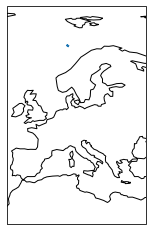

In [134]:
fig = plt.figure()

ax = fig.add_subplot(111, projection=ccrs.Robinson())
ax.coastlines()
# ax.set_global()
# ax.set_extent([-30, 50, 50, 85], crs=ccrs.PlateCarree())
ax.set_extent([-10, 30, 25, 85], crs=ccrs.PlateCarree())
# ax.set_extent([179, 181, 29, 32], crs=ccrs.PlateCarree())

ax.plot(combined['Longitude'].where(filter), combined['Latitude'].where(filter), linewidth=2, transform=ccrs.PlateCarree());

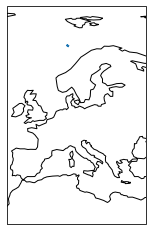

In [138]:
fig = plt.figure()

ax = fig.add_subplot(111, projection=ccrs.Robinson())
ax.coastlines()
# ax.set_global()
# ax.set_extent([-30, 50, 50, 85], crs=ccrs.PlateCarree())
ax.set_extent([-10, 30, 25, 85], crs=ccrs.PlateCarree())
# ax.set_extent([179, 181, 29, 32], crs=ccrs.PlateCarree())

ax.plot(combined['Longitude'].where(filter), combined['Latitude'].where(filter), linewidth=2, transform=ccrs.PlateCarree());

In [ ]:
# Read in the CloudSat R05 data and create the monthly mean of 
# information of variables: http://www.cloudsat.cira.colostate.edu/data-products/level-2c/2c-snow-profile?term=90
# Documentation: http://www.cloudsat.cira.colostate.edu/sites/default/files/products/files/2C-SNOW-PROFILE_PDICD.P1_R05.rev0_.pdf


# 1D variables
# 'snowfall_rate_sfc'

# 2D variables
# 'Height'
# 'snowfall_rate'
# 'snow_water_content'


# necessary variables
        # 'Latitude'
        # 'Longitude'
        # 'Vertical_binsize'
        # profile times as YYYYMMDD-HH-MM-SS

In [ ]:
# supress warnings
import warnings
warnings.filterwarnings('ignore') # don't output warnings

# import packages
from imports import(glob, pySD, pyHDF, read_var_eos, xr, np, datetime, timedelta, fct)

# reload imports
%load_ext autoreload
%autoreload 2

In [ ]:
year = 2008


one_D = False
two_D = True



available_month = {
                   '1':'01',
                   '2':'02',
                   '3':'03',
                   '4':'04', 
                   '5':'05', 
                   '6':'06', 
                   '7':'07',
                   '8':'08', 
                   '9':'09', 
                   '10':'10', 
                   '11':'11', 
                   '12':'12'
                  }



In [ ]:
# datapath = '/tos-project2/NS9600K/data'
path = '/scratch/franzihe'
datapath = '{:}/input/cloudsat/2C-SNOW-PROFILE.P1_R05'.format(path)
ff_cs = sorted(glob('{}/{}/*/*.hdf'.format(datapath, year, )))


In [ ]:
filepath = '{:}/input/cloudsat/ECMWF-AUX.P_R05'.format(path)
ff_ec = sorted(glob('{}/{}/*/*.hdf'.format(filepath, year, )))


In [ ]:
if one_D == True:
    # 1D variables
    variables = {
                # 'DEM_elevation'               : 'm',        #Elevation in meters above Mean Sea Level. A value of -9999 indicates ocean. A value of 9999 indicates an error in calculation of the elevation.
                # 'Vertical_binsize'            : '',         #effective vertical height of the radar range bin.
                'snowfall_rate_sfc'           : 'mm h-1',   #Surface snowfall rate in mm of liquid water per hour. The specified range is typical. 
                # 'snowfall_rate_sfc_uncert'    : '',         #The estimated 1-sigma uncertainty of the surface snowfall rate in mm of liquid water per hour. The specified range is typical.
                # 'snowfall_rate_sfc_confidence': '',         #Flag indicating the relative quality of the surface snowfall rate estimate. 4: High confidence
    }

if two_D == True:
    # 2D variables
    variables = {
                # 'Height'                    : '',               #Height of the radar range bins in meters above mean sea level.
                'snowfall_rate'             : 'mm h-1',         #Profile of snowfall rates in the precipitating column in mm of liquid water per hour. The specified range is typical.
                # 'snowfall_rate_uncert'      : '',               #The estimated 1-sigma uncertainties of the snowfall rates in the precipitating column. The specified range is typical.
                # 'snow_water_content'        : 'g kg-1',          #Profile of snow water content in the precipitating column in grams per m^3. The specified range is typical.
                # 'snow_water_content_uncert' : '',                #The estimated 1-sigma uncertainties of the snow water contents in the precipitating column in grams per m^3. The specified range is typical.
    }

In [ ]:
pressure_grid = np.array([24., 25., 26., 27., 28., 29., 30., 32., 33., 
                            34., 35., 37., 38., 40., 41., 43., 44., 45.,
                            48., 50., 52., 54., 55., 58., 60., 63., 65., 
                            68., 70., 73., 75., 80., 83., 85., 90., 93., 
                            98.,100., 105., 110., 113., 115., 120., 125., 130., 
                            135., 140., 145., 155., 160., 165., 170., 180., 185., 
                            190., 200., 210., 215., 225., 230., 240., 250., 260., 
                            270., 280., 290., 300., 310., 320., 330., 345., 360., 
                            370., 380., 395., 400., 425., 440., 450., 470., 480., 
                            500., 515., 530., 550., 570., 585., 600., 625., 645., 
                            665., 685., 700., 725., 750., 770., 800., 825., 850.,
                            870., 900., 925., 950., 988., 1000., 1010,  1015,  1020,
                            np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan,
                            np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan])

In [ ]:
counter = 0
for month, mm in available_month.items():
    if one_D == True:
        ds = xr.Dataset(
                data_vars=dict(
                    Profile_time=(['nray'], np.empty(shape = (0,), dtype='datetime64[s]')),
                    Latitude    =(['nray'], np.empty(shape = (0,), )),
                    Longitude   =(['nray'], np.empty(shape = (0,), )),
                    Data_quality=(['nray'], np.empty(shape = (0,), )),
                                ),
                                coords=dict(nray=([]), nbin=([])), 
                                attrs=None)
    if two_D == True:
        ds = xr.Dataset(
                data_vars=dict(
                    Profile_time=(['nray'], np.empty(shape = (0,), dtype='datetime64[s]')),
                    Latitude    =(['nray'], np.empty(shape = (0,), )),
                    Longitude   =(['nray'], np.empty(shape = (0,), )),
                    Data_quality=(['nray'], np.empty(shape = (0,), )),
                    pressure    =(['nray', 'nbin'], np.empty(shape = (0, 0), )),
                    temperature =(['nray', 'nbin'], np.empty(shape = (0, 0), ))
                                ),
                                coords=dict(nray=([]), nbin=([])), 
                                attrs=None)
    for var, unit in variables.items():
        # create new variable 
        if one_D == True:
            ds[var] = xr.DataArray(
                    data = np.full(shape = (0,), fill_value=np.nan),
                    dims = ['nray'],
                    attrs= {'units': unit}
                )
        if two_D == True:
            ds[var] = xr.DataArray(
                    data = np.full(shape = (0, 0), fill_value=np.nan ),
                    dims = ['nray', 'nbin'],
                    attrs= {'units': unit}
                )
        filename = '{var}_{year}{month}.nc'.format(var = var, year = year, month = mm)
        savepath = '{path}/output/cloudsat/2C-SNOW_onemonth_onevariable/{year}/'.format(path = path, year = year)
        files = glob(savepath + filename)
            
        if savepath + filename in files:
            print('{savepath}{filename} is downloaded'.format(savepath = savepath, filename = filename))
            counter += 1
            print('Have downloaded in total: {:} files'.format(str(counter)))
        else:
            for i in range(2):#len(ff_cs)):
                # for i in range(6): # read in one file and bring 2D Variables on a common pressure grid 
                year = int(ff_cs[i].split('/')[-3])
                doy  = int(ff_cs[i].split('/')[-2])   # day of the year
                _t = datetime(year, 1, 1) + timedelta(doy -1)    # create date

                if _t.month != int(month):
                    continue
                elif _t.month == int(month):
                    
                    # Read in CloudSat
                    f_SD_ptr = pySD.SD(ff_cs[i], pySD.SDC.READ)
                    f_VD_ptr = pyHDF.HDF(ff_cs[i], pyHDF.HC.READ)

                    # get profile times from file
                    Profile_time = read_var_eos.get_profile_times(f_VD_ptr)

                    # get geolocation
                    _lat = read_var_eos.get_1D_var(f_VD_ptr, 'Latitude') #Spacecraft Geodetic Latitude.
                    _lon = read_var_eos.get_1D_var(f_VD_ptr, 'Longitude') #Spacecraft geodetic longitude

                    # get data quality
                    _Data_quality = read_var_eos.get_1D_var(f_VD_ptr, 'Data_quality') #Flags indicating data quality. If 0, then data is of good quality.

                    # get variable
                    if one_D == True:
                        _var = read_var_eos.get_1D_var(f_VD_ptr, var) 
                    if two_D == True:
                        _var = read_var_eos.get_2D_var(f_SD_ptr, f_VD_ptr, var)
                        
                    # assign np.nan where missing vallues
                    _var[np.where(_var == -999.)] = np.nan
                                
                    f_VD_ptr.close()
                    f_SD_ptr.end()

                    # create dataset
                    if one_D == True:
                        _ds = fct.create_xr_1D_ds(Profile_time, _lat, _lon, _Data_quality, var, unit, _var)


                        
                    if two_D == True:
                        # Read in ECMWF-Aux files for pressure averaging for 2D files
                        f_SD_ptr = pySD.SD(ff_ec[i], pySD.SDC.READ)
                        f_VD_ptr = pyHDF.HDF(ff_ec[i], pyHDF.HC.READ)

                        # # Sometimes different data products don’t have the same dimensions, e.g. 2007 granule 3853
                        # if lwc.shape != iwc.shape:
                        #     dimension_failure += 1
                        #     print(‘Skipping granule (dimension failure)...’)
                        #     continue
                                    
                        # get 2D variable
                        pressure = read_var_eos.get_2D_var(f_SD_ptr, f_VD_ptr, 'Pressure')
                        temperature = read_var_eos.get_2D_var(f_SD_ptr, f_VD_ptr, 'Temperature')
                                    
                        # convert pressure into hPa
                        pressure[np.where(pressure == -999.)] = np.nan
                        pressure = pressure /100.
                                    
                        # assign np.nan where missing vallues
                        temperature[np.where(temperature == -999.)] = np.nan
                                            
                        f_VD_ptr.close()
                        f_SD_ptr.end()
                        # create dataset
                        _ds = fct.create_xr_2D_ds(Profile_time, _lat, _lon, _Data_quality, pressure, temperature, var, unit, _var)

                        # assign pressure grid coordinate
                        _ds = _ds.assign_coords(pressure_grid=pressure_grid)

                        # define new variable to be on the pressure grid
                        _ds[var+'_regrid'] = xr.DataArray(data=np.full(shape = (len(_ds.nray), len(_ds.pressure_grid)), fill_value = np.nan), dims=dict(nray=([]), pressure_grid=([])),)

                        # put the 2D variable on equal pressure grid
                        for t in range(len(_ds.nray)):
                            for k in range(len(_ds.pressure_grid)):
                                # First, find the index of the grid point nearest a specific pressure level
                                abs_pressure = np.abs(_ds.pressure.isel(nray = t) - _ds.pressure_grid.isel(pressure_grid = k))
                                c = abs_pressure

                                try:
                                    ([xloc, ]) = np.where(c == np.nanmin(c))
                                    # Now I can use that index location to get the values at the x/y diminsion
                                    _ds[var+'_regrid'][t, xloc] = _ds.snowfall_rate.isel(nray = t).sel(nbin = xloc)
                                
                                except:
                                    print('c values', np.nanmin(c))
                                    _ds[var+'_regrid'][t, xloc] = np.nan
                                    
                        _ds = _ds.drop_vars(var)                        

                    ds = xr.concat([ds, _ds], dim = 'nray')

            ds.to_netcdf(path = '{savepath}{filename}'.format(savepath = savepath, filename = filename))
            print('file saved: {savepath}{filename}'.format(savepath = savepath, filename = filename))



In [ ]:
_ds